In [1]:
import os
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn import decomposition
from sklearn import preprocessing
from sklearn import manifold
from sklearn import metrics
from tqdm.auto import tqdm
from joblib import Parallel, delayed
import urllib.request
import shutil
import zipfile
from scipy.stats import mode

In [2]:
fold = "../random_20000_data/"
# .npyファイルからデータをロード
x = np.load(f'{fold}x_20000_random.npy')
label = np.load(f"{fold}label_20000_random.npy")

# データの形状を表示
print("Shape of the loaded x data:", x.shape)
print("Shape of the loaded label data:", label.shape)

Shape of the loaded x data: (20000, 500)
Shape of the loaded label data: (20000, 500)


In [3]:
# 各行の最頻値を計算して1次元ラベルに変換
label_reconstructed = mode(label, axis=1).mode.flatten()
print(label_reconstructed.shape)

(20000,)


In [4]:
print(x.shape)
print(label_reconstructed.shape)

(20000, 500)
(20000,)


In [5]:
print(pd.Series(label_reconstructed).value_counts())

7.0    3261
5.0    3193
6.0    2924
1.0    2507
2.0    2491
4.0    2422
8.0    2349
3.0     853
Name: count, dtype: int64


Shape of the reconstructed label data: (20000,)


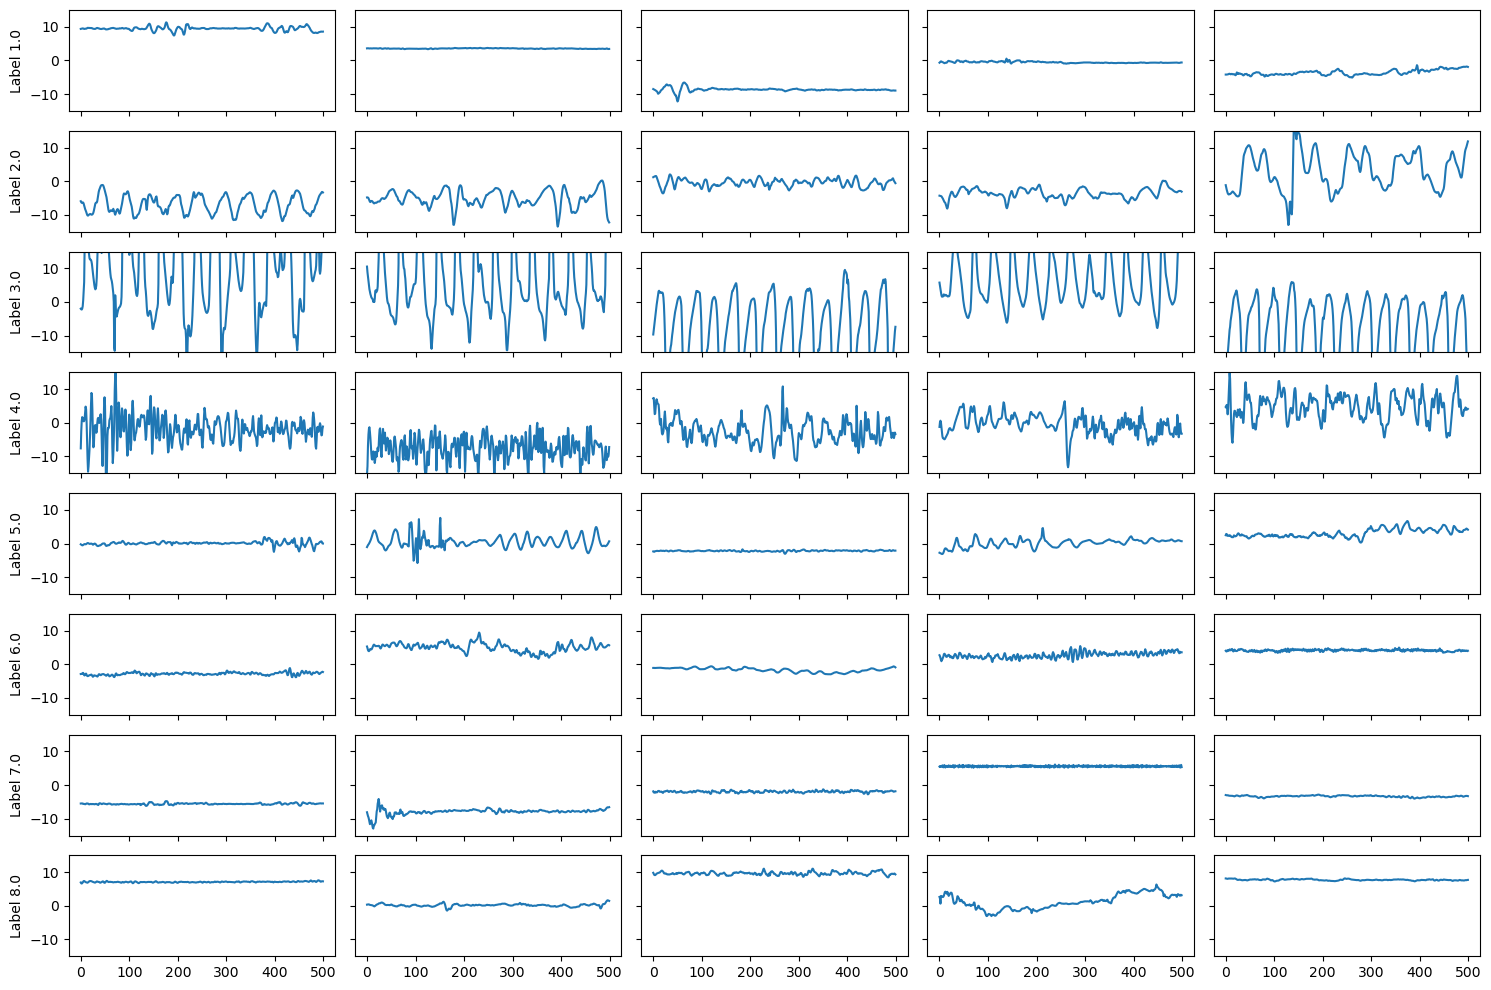

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import mode

fold = "../random_20000_data/"
# .npyファイルからデータをロード
x = np.load(f'{fold}x_20000_random.npy')
label = np.load(f"{fold}label_20000_random.npy")

# 各行の最頻値を計算して1次元ラベルに変換
label_reco = mode(label, axis=1).mode.flatten()

# 変換後のラベルデータの形状を表示
print("Shape of the reconstructed label data:", label_reco.shape)

# 一意なラベルを取得
unqY = np.unique(label_reco)

# 各アノテーションについて5つのグラフを描画
NPLOTS = 5
fig, axs = plt.subplots(len(unqY), NPLOTS, sharex=True, sharey=True, figsize=(15, 10))

# 各ラベルについてのプロット
for y, row in zip(unqY, axs):
    indices = np.where(label_reco
 == y)[0]
    
    # サンプリングインデックス数がNPLOTS未満の場合の対応
    if len(indices) < NPLOTS:
        sampled_indices = indices
    else:
        sampled_indices = np.random.choice(indices, size=NPLOTS, replace=False)
    
    row[0].set_ylabel(f'Label {y}')
    for x_data, ax in zip(x[sampled_indices], row):
        ax.plot(x_data)
        ax.set_ylim(-15, 15)

fig.tight_layout()
plt.show()


In [13]:
print("x shape:", x.shape)
print("label reconstructed shape:", label_reco.shape)

x shape: (20000, 500)
label reconstructed shape: (20000,)


xには１サンプルに500のデータが入っている。  
これをそのままランダムフォレストのアンサンブル学習を行う

# train/test split

In [14]:
from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y = train_test_split(x, label_reco, train_size=16000)

In [15]:
# 分割後のデータの形状を表示
print("Shape of train_x:", train_x.shape)
print("Shape of test_x:", test_x.shape)
print("Shape of train_y:", train_y.shape)
print("Shape of test_y:", test_y.shape)

Shape of train_x: (16000, 500)
Shape of test_x: (4000, 500)
Shape of train_y: (16000,)
Shape of test_y: (4000,)


# train a random forest classifier

In [16]:
clf = BalancedRandomForestClassifier(
    n_estimators=2000,
    replacement=True,
    sampling_strategy='not minority',
    oob_score=True,
    n_jobs=8,
    random_state=42,
    verbose=1
)
clf.fit(train_x,train_y) # 訓練データを使ってまずランダムフォレストを学習している。

c:\Users\kaiha\anaconda3\envs\labo_Okita\lib\site-packages\imblearn\ensemble\_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warning and adopt the future behaviour.
  warn(
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.8s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   14.7s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:   34.0s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:  1.0min
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:  1.6min
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed:  2.4min
[Parallel(n_jobs=8)]: Done 2000 out of 2000 | elapsed:  2.6min finished


BalancedRandomForestClassifier(n_estimators=2000, n_jobs=8, oob_score=True,
                               random_state=42, replacement=True,
                               sampling_strategy='not minority', verbose=1)

In [17]:
Y_test_pred = clf.predict(test_x) # 学習器の性能をみる テストデータで
print('\nClassifier performance')
print('Out of sample:\n', metrics.classification_report(test_y, Y_test_pred, zero_division=0))
"""
# This will be the training set
Y_in_train = clf.oob_decision_function_.astype('float32') # OOBデータを用いて予測。結果をY_in_trainに入れている。
# This will be the test set
Y_in_test = clf.predict_proba(X_test).astype('float32') # クラス所属確率の予測も入っている。Y_test_predとは違って他のクラスへの所属確率も出力している点に留意"""

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:    0.8s



Classifier performance
Out of sample:
               precision    recall  f1-score   support

         1.0       0.36      0.40      0.38       498
         2.0       0.60      0.65      0.63       479
         3.0       0.78      0.95      0.86       156
         4.0       0.65      0.69      0.67       484
         5.0       0.43      0.63      0.51       634
         6.0       0.36      0.30      0.33       586
         7.0       0.34      0.28      0.30       674
         8.0       0.25      0.13      0.17       489

    accuracy                           0.45      4000
   macro avg       0.47      0.50      0.48      4000
weighted avg       0.43      0.45      0.44      4000



[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done 2000 out of 2000 | elapsed:    1.3s finished


"\n# This will be the training set\nY_in_train = clf.oob_decision_function_.astype('float32') # OOBデータを用いて予測。結果をY_in_trainに入れている。\n# This will be the test set\nY_in_test = clf.predict_proba(X_test).astype('float32') # クラス所属確率の予測も入っている。Y_test_predとは違って他のクラスへの所属確率も出力している点に留意"